In [1]:
import gc
import logging
logging.disable(logging.WARNING)
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import mixed_precision
from tensorflow.keras.utils import plot_model
import tensorflow_probability as tfp
import tensorflow_addons as tfa

mixed_precision.set_global_policy('mixed_float16')
print(tf.__version__)

2.6.3


In [2]:
# Load data
df = pd.read_parquet('E:/train_low_mem.parquet')
df.drop(['row_id', 'time_id'], inplace=True, axis=1)
y = df.pop("target")
investment_id = df.pop("investment_id")

In [3]:
def preprocess(x, y):
    # flatten and normalize
    # return x, tf.math.sign(y) * tf.math.log1p(tf.math.log1p(tf.math.abs(y)))
    return x, y

def post_process(y):
    y = list(map(np.ndarray.item, list(y)))
    y = tf.math.sign(y) * (tf.math.expm1(tf.math.expm1(tf.math.sign(y) * y)))
    return y.numpy()

def make_dataset(feature, y, batch_size=10240, mode='train'):
    ds = tf.data.Dataset.from_tensor_slices((feature, y))
    ds = ds.map(preprocess)
    if mode == "train": ds = ds.shuffle(10240, seed=69)  # only shuffle when training
    ds = ds.batch(batch_size).cache().prefetch(tf.data.experimental.AUTOTUNE)
    return ds


# Pearson correlation coefficient loss and metrics
def pearson_corr(y_true, y_pred, axis=-1):
    return tfp.stats.correlation(tf.squeeze(y_pred), tf.squeeze(y_true), sample_axis=axis, event_axis=None)

def pearson_corr_loss(y_true, y_pred, axis=-1):
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    corr_loss = 1 - pearson_corr(y_true, y_pred, axis=axis)
    return corr_loss + mse

In [4]:
# Model
def build_model():
    features_inputs = Input((300, ), name='feature_in', dtype=tf.float16)
    x = GaussianNoise(0.1)(features_inputs)
    x = Dense(256)(x)
    x = tfa.activations.mish(x)
    x = LayerNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(256)(x)
    x = tfa.activations.mish(x)
    x = LayerNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(256)(x)
    x = tfa.activations.mish(x)
    x = LayerNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(256)(x)
    x = tfa.activations.mish(x)
    x = LayerNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(128)(x)
    x = tfa.activations.mish(x)
    x = LayerNormalization()(x)
    x = Dropout(0.35)(x)
    x = Dense(64)(x)
    x = tfa.activations.mish(x)
    x = LayerNormalization()(x)
    x = Dropout(0.3)(x)
    xOut = Dense(1, name='output', dtype=tf.float32)(x)

    model = Model(inputs=features_inputs, outputs=xOut)
    # todo: try opt below with mish activation
    opt = tfa.optimizers.RectifiedAdam(1e-2)
    opt = tfa.optimizers.Lookahead(opt, sync_period=6, slow_step_size=0.5)
    # opt = tf.keras.optimizers.Adam(learning_rate=1e-3, decay=5e-4)
    model.compile(loss='mse', optimizer=opt, metrics=[pearson_corr, 'mse'])
    return model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
feature_in (InputLayer)         [(None, 300)]        0                                            
__________________________________________________________________________________________________
gaussian_noise (GaussianNoise)  (None, 300)          0           feature_in[0][0]                 
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          77056       gaussian_noise[0][0]             
__________________________________________________________________________________________________
tf.convert_to_tensor (TFOpLambd (None, 256)          0           dense[0][0]                      
______________________________________________________________________________________________

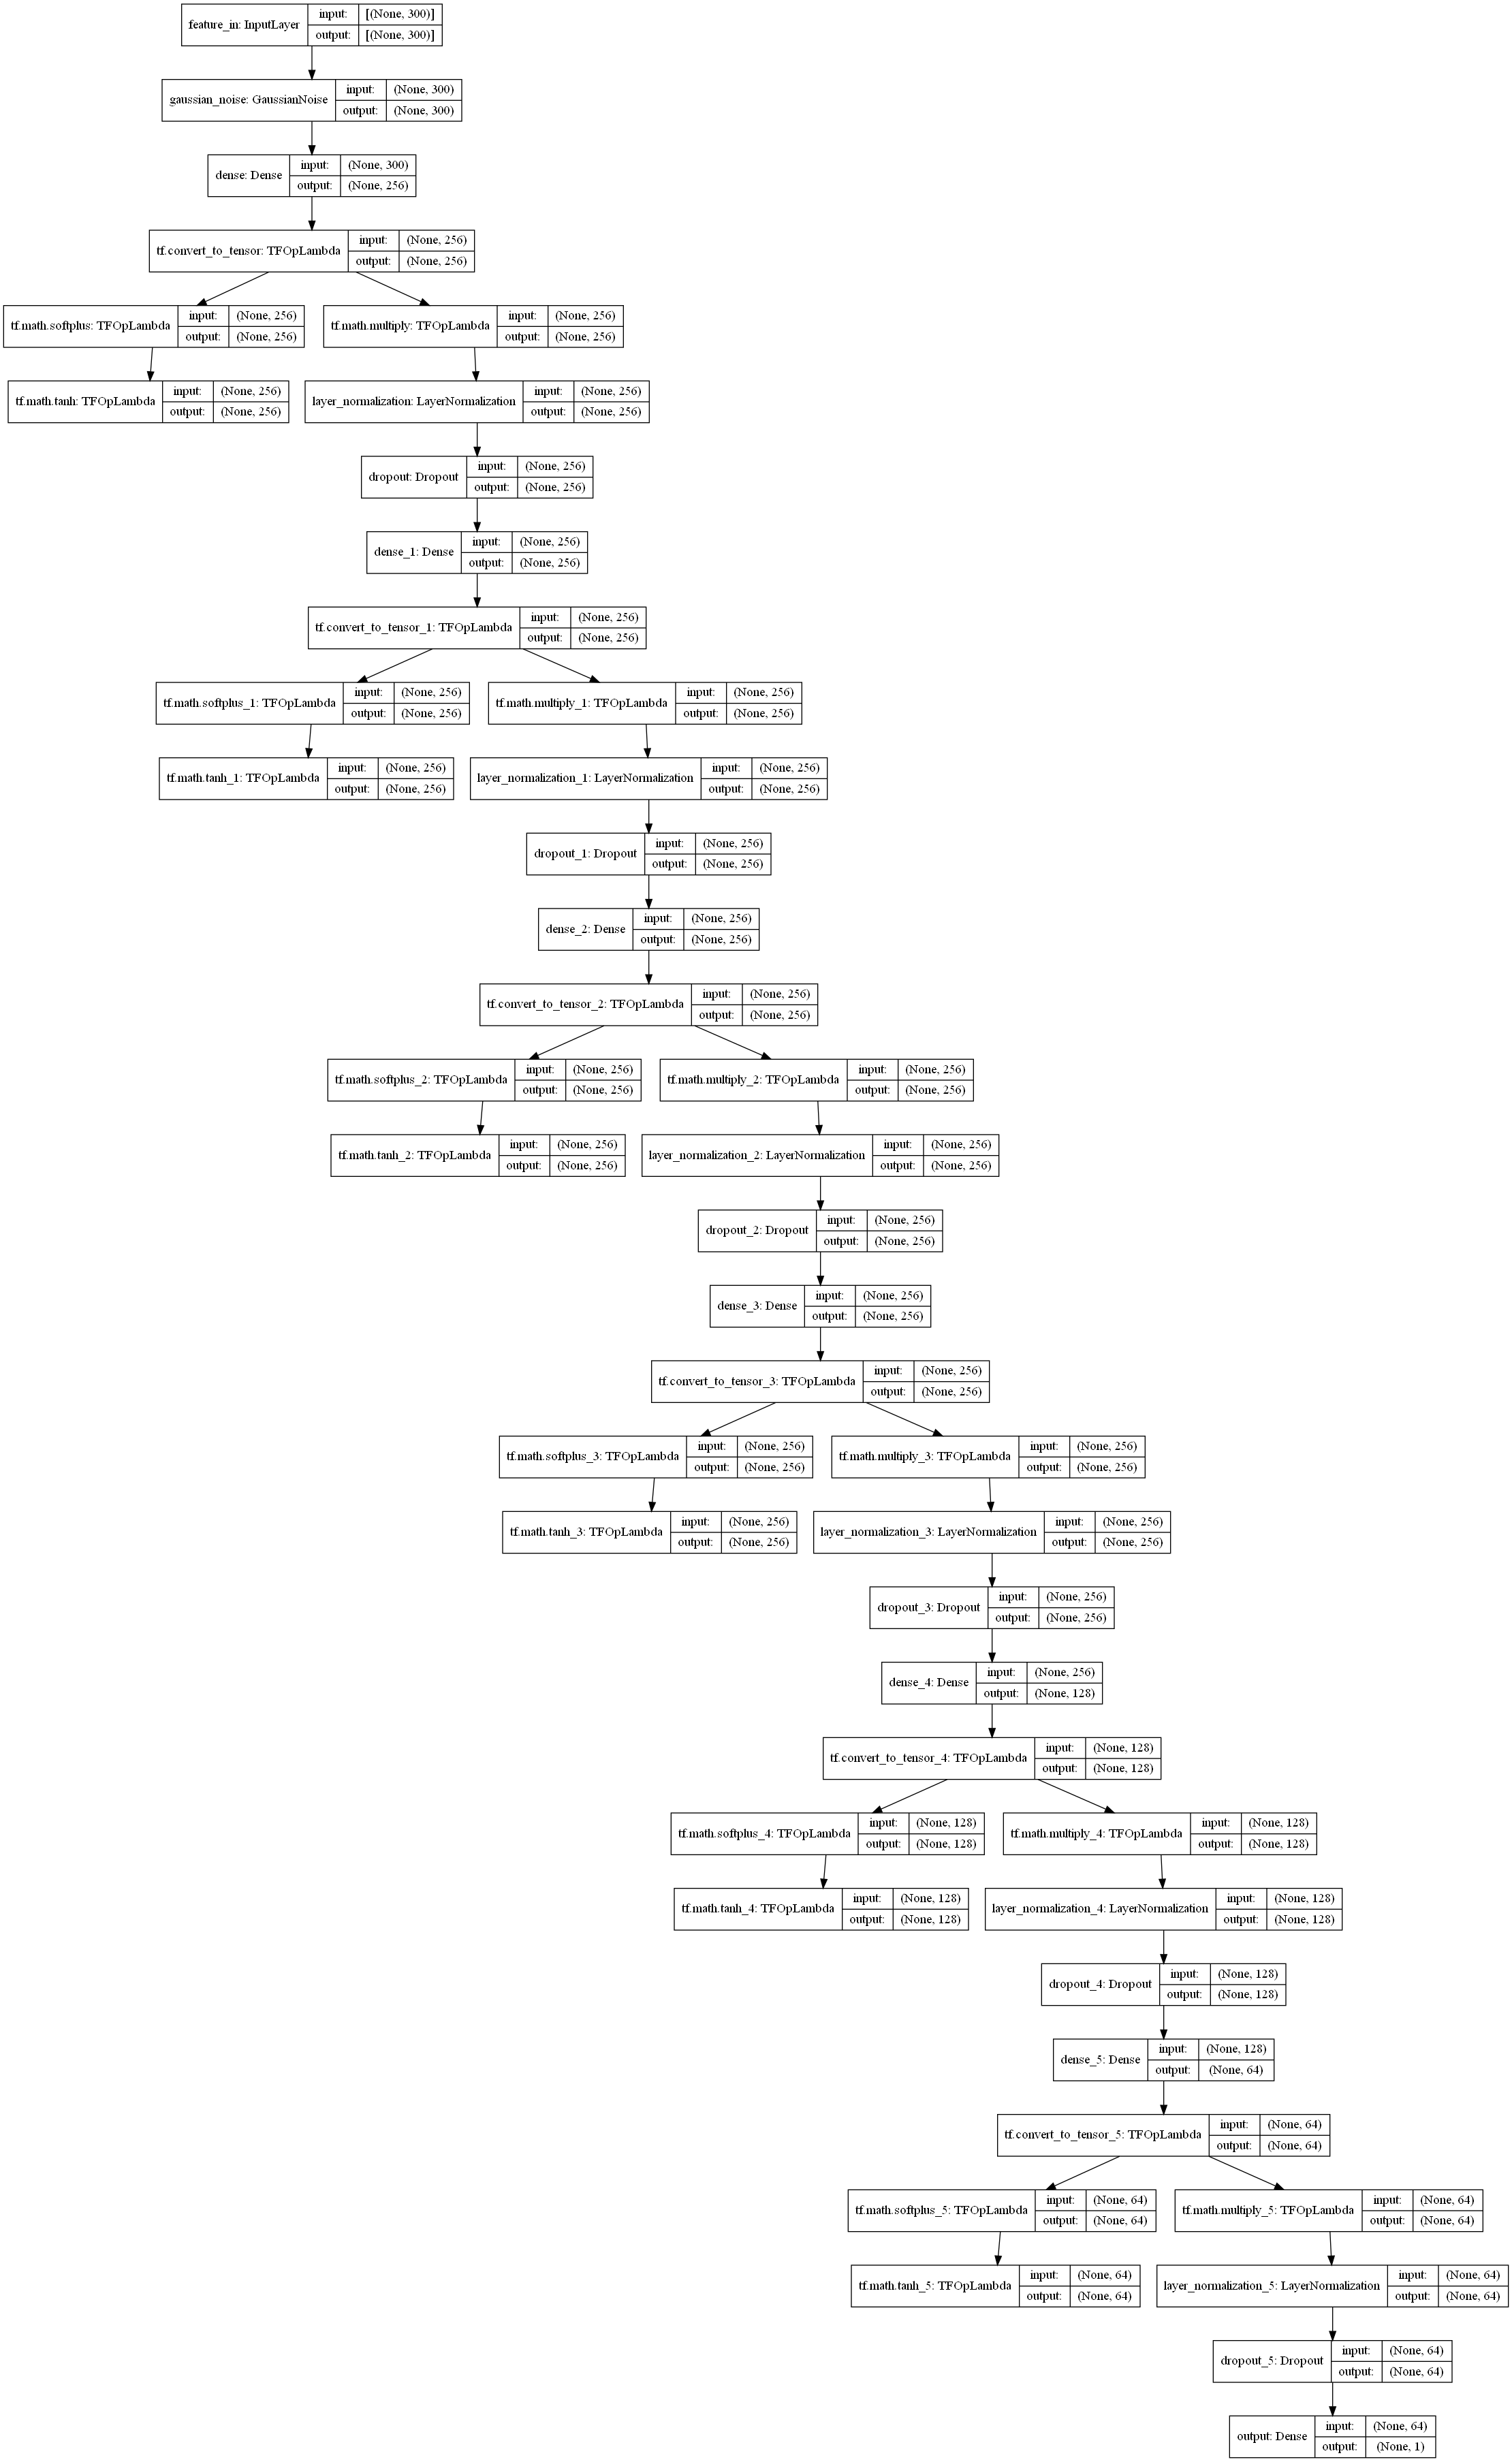

In [5]:
model = build_model()
model.summary()
plot_model(model, to_file='model.png', show_shapes=True)

In [7]:
import scipy
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=69)
# group_time_series_split = GroupTimeSeriesSplit(n_folds=6, holdout_size=200, groups=df['time_id'])
models = []
for index, (train_indices, valid_indices) in enumerate(kfold.split(df, investment_id)):
    print(f'Model {index}')
    X_train, X_val = df.iloc[train_indices], df.iloc[valid_indices]
    y_train, y_val = y.iloc[train_indices], y.iloc[valid_indices]
    train_ds = make_dataset(X_train, y_train)
    valid_ds = make_dataset(X_val, y_val, mode="valid")
    model = build_model()
    callbacks = [tf.keras.callbacks.ModelCheckpoint(f"model_{index}", monitor='val_mse', save_best_only=True, mode='min'),
                 tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_mse', verbose=1, restore_best_weights=True, mode='min'),
                 tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=6, verbose=1, monitor='val_mse', mode='min')]
    history = model.fit(train_ds, epochs=50, validation_data=valid_ds, callbacks=callbacks)
    models.append(load_model(f"model_{index}", custom_objects={'pearson_corr': pearson_corr, 'pearson_corr_loss': pearson_corr_loss}))

    pearson_score = scipy.stats.pearsonr(model.predict(valid_ds).ravel(), y_val.values)[0]
    print('Pearson:', pearson_score)
    del X_train
    del X_val
    del y_train
    del y_val
    del train_ds
    del valid_ds
    del model
    gc.collect()

C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=6.
  warnings.warn(


Model 0
Epoch 1/50
256/256 [==============================] - 15s 34ms/step - loss: 1.0540 - pearson_corr: 0.0212 - mse: 1.0540 - val_loss: 0.8377 - val_pearson_corr: 0.0813 - val_mse: 0.8377
Epoch 2/50
256/256 [==============================] - 7s 27ms/step - loss: 0.8441 - pearson_corr: 0.0724 - mse: 0.8441 - val_loss: 0.8357 - val_pearson_corr: 0.0853 - val_mse: 0.8357
Epoch 3/50
256/256 [==============================] - 3s 13ms/step - loss: 0.8383 - pearson_corr: 0.1025 - mse: 0.8383 - val_loss: 0.8343 - val_pearson_corr: 0.1029 - val_mse: 0.8343
Epoch 4/50
256/256 [==============================] - 3s 13ms/step - loss: 0.8349 - pearson_corr: 0.1209 - mse: 0.8349 - val_loss: 0.8331 - val_pearson_corr: 0.1081 - val_mse: 0.8331
Epoch 5/50
256/256 [==============================] - 3s 12ms/step - loss: 0.8328 - pearson_corr: 0.1304 - mse: 0.8328 - val_loss: 0.8316 - val_pearson_corr: 0.1126 - val_mse: 0.8316
Epoch 6/50
256/256 [==============================] - 3s 12ms/step - loss: 0

In [8]:
from ubiquantEmulator import TimeSeriesAPI

def preprocess_test(feature):
    return feature, 0

def post_process(y):
    y = list(map(np.ndarray.item, list(y)))
    y = tf.math.sign(y) * (tf.math.expm1(tf.math.expm1(tf.math.sign(y) * y)))
    return y.numpy()

def make_test_dataset(feature, batch_size=10240):
    ds = tf.data.Dataset.from_tensor_slices(feature)
    ds = ds.map(preprocess_test)
    ds = ds.batch(batch_size).cache().prefetch(tf.data.experimental.AUTOTUNE)
    return ds


def inference(models, ds):
    y_preds = []
    for model in models:
        y_pred = model.predict(ds)
        y_preds.append(y_pred)
    return np.mean(y_preds, axis=0)  # ensemble

models = [load_model(f"model_{index}", custom_objects={'pearson_corr': pearson_corr, 'pearson_corr_loss': pearson_corr_loss}) for index in range(6)]
# models = [load_model(f"model_comb", custom_objects={'pearson_corr': pearson_corr, 'pearson_corr_loss': pearson_corr_loss})]
# models += [load_model(f"1/model_{index}", custom_objects={'pearson_corr': pearson_corr, 'pearson_corr_loss': pearson_corr_loss}) for index in range(6)]
# test = pd.read_parquet('E:/train_low_mem.parquet')
# time_ids = df['time_id'].unique()
# test = test.loc[test['time_id'].isin(time_ids)]  # take last 200 time id rows from df
test = pd.read_csv('kaggle/input/ubiquant-market-prediction/train.csv', engine='pyarrow')
iter_test = TimeSeriesAPI(test)
for n, (test_df, sample_prediction_df) in enumerate(iter_test):
    ds = make_test_dataset(test_df.loc[:, 'f_0':'f_299'])
    sample_prediction_df['target'] = inference(models, ds)
    iter_test.predict(sample_prediction_df)
print(sample_prediction_df)
print(f'Pearson: {iter_test.score()}')

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set. ;)
       row_id    target
18211     8_1  0.040270
18212     8_2  0.066025
18213     8_6 -0.010176
18214     8_7 -0.012621
18215     8_8 -0.004875
...       ...       ...
19995  8_2961 -0.084331
19996  8_2963 -0.014790
19997  8_2964 -0.289378
19998  8_2965  0.007496
19999  8_2966 -0.066639

[1789 rows x 2 columns]
Pearson: (       row_id    target  prediction
0         0_1 -0.300875    0.115682
1         0_2 -0.231040   -0.056063
2         0_6  0.568807    0.016910
3         0_7 -1.064780   -0.116260
4         0_8 -0.531940   -0.010364
...       ...       ...         ...
19995  8_2961  2.395875   -0.084331
19996  8_2963  0.293830   -0.014790
19997  8_2964  0.295464   -0.289378
19998  8_2965 -0.722136    0.007496
19999  8_2966 -0.268326   -0.066639

[20000 rows x 3 columns], 0.18142325503702794)


In [9]:
import ubiquant
env = ubiquant.make_env()
iter_test = env.iter_test()
for (test_df, sample_prediction_df) in iter_test:
    ds = make_test_dataset(test_df.loc[:, 'f_0':'f_299'], test_df["investment_id"])
    sample_prediction_df['target'] = inference(models, ds)
    env.predict(sample_prediction_df)
print(sample_prediction_df)
print(f'Pearson: {scipy.stats.pearsonr(sample_prediction_df["target"].values, test_df["target"].values)[0]}')

ModuleNotFoundError: No module named 'ubiquant'